In [241]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

In [242]:
# Import future ENT appointments
data = pd.read_csv("../future_appts_trans_ENT.csv")
data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,17479744,57,27.45,1,0,1,1,0,0,0,...,2024-06-26,3,7,0,6,0,10,1,0,3
1,17631073,17,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,1,0,3
2,17659262,27,21.70,0,0,0,4,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,2
3,17659348,57,21.70,0,0,0,3,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,3
4,17659361,27,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,20183628,47,27.45,0,0,1,2,0,0,0,...,2024-06-19,5,7,0,6,0,10,1,0,1
2561,20183649,57,40.00,0,1,0,1,0,0,0,...,2024-06-08,3,7,0,5,0,10,2,0,3
2562,20183782,32,21.70,0,0,0,4,0,0,0,...,2024-05-25,3,7,0,7,0,10,6,0,1
2563,20183795,62,39.45,0,0,0,1,0,0,0,...,2024-06-17,3,7,0,6,0,10,3,0,1


In [243]:
# Filter for surgeons & new appointments only
surgeon_new = data[data["reason_display"].isin(["Adult ENT New", "Adult ENT Thyroid New"])]

In [244]:
# Within the surgeons & new appointments only, filter for very high risk appointments
surgeon_new_very_high = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] == 4]

In [245]:
# Count number of unique appointment durations
surgeon_new["appt_duration"].value_counts()

appt_duration
15.0    1962
30.0     198
20.0      33
10.0      17
75.0       3
Name: count, dtype: int64

In [246]:
# Split out the appointment durations
surgeon_new_10 = surgeon_new[surgeon_new["appt_duration"] == 10]
surgeon_new_15 = surgeon_new[surgeon_new["appt_duration"] == 15]
surgeon_new_20 = surgeon_new[surgeon_new["appt_duration"] == 20]
surgeon_new_30 = surgeon_new[surgeon_new["appt_duration"] == 30]
surgeon_new_75 = surgeon_new[surgeon_new["appt_duration"] == 75]

# Split out the very high risk appointments
surgeon_new_very_high_10 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 10]
surgeon_new_very_high_15 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 15]
surgeon_new_very_high_20 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 20]
surgeon_new_very_high_30 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 30]
surgeon_new_very_high_75 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 75]

In [247]:
# Group weekswaiting as per NHS guidelines
data["weekswaiting"]
data["weekswaiting_grouped"] = pd.cut(data["weekswaiting"], bins=[0, 17, 51, 76, float('inf')], labels=["0-17", "18-51", "52-77", ">78"])
data[["weekswaiting","weekswaiting_grouped"]]

,weekswaiting,weekswaiting_grouped
0,53.0,52-77
1,82.0,>78
2,55.0,52-77
3,55.0,52-77
4,54.0,52-77
...,...,...
2560,44.0,18-51
2561,13.0,0-17
2562,49.0,18-51
2563,11.0,0-17


### V1: overbook any (other risk levels) into very high risk based on weeks waiting

In [248]:
# # Sort the appointments by weekswaiting (descending; all except the very high risk ones)
# weekswaiting_desc = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
#     # ? Create a new df with >78 weeks waiting - prioritise these patients; but if < # of slots, then fill with 18-52 week patients?



# Sort the individual appointment durations by weekswaiting (descending; all except the very high risk ones)
weekswaiting_desc_10 = surgeon_new_10[surgeon_new_10["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15 = surgeon_new_15[surgeon_new_15["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20 = surgeon_new_20[surgeon_new_20["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30 = surgeon_new_30[surgeon_new_30["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75 = surgeon_new_75[surgeon_new_75["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)

In [249]:
# Create queues for the 'other risk level' appointments
#queue = deque(weekswaiting_desc["appointment_id"])
queue10 = deque(weekswaiting_desc_10["appointment_id"])
queue15 = deque(weekswaiting_desc_15["appointment_id"])
queue20 = deque(weekswaiting_desc_20["appointment_id"])
queue30 = deque(weekswaiting_desc_30["appointment_id"])
queue75 = deque(weekswaiting_desc_75["appointment_id"])

# Sum the duration of queued appointments
queue_time = len(queue10)*10 + len(queue15)*15 + len(queue20)*20 + len(queue30)*30 + len(queue75)*75
queue_time

32530

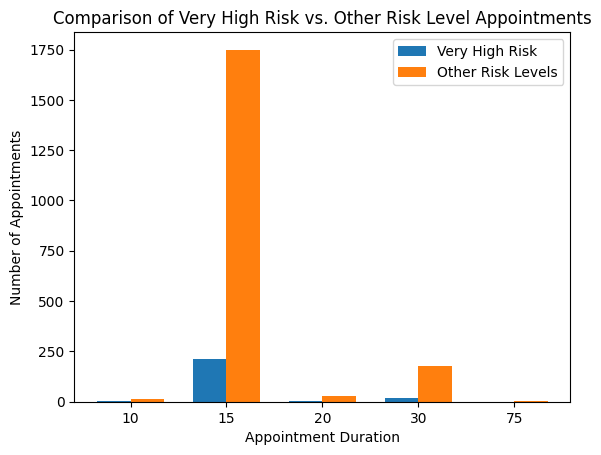

In [250]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10),
    len(queue15),
    len(queue20),
    len(queue30),
    len(queue75),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label='Very High Risk')
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label='Other Risk Levels')

# Add labels, title, and legend
ax.set_xlabel('Appointment Duration')
ax.set_ylabel('Number of Appointments')
ax.set_title('Comparison of Very High Risk vs. Other Risk Level Appointments')
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Display the plot
plt.show()

In [251]:
# Function to overbook the very high risk appointments
def overbook_appointments(very_high_group, queue):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        if queue:
            # Pop the earliest appointment from the queue
            earliest_appointment_id = queue.popleft()
            # Overbook the very high risk slot with the remaining appointment
            overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
        else:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    return overbooked_appointments

# Overbook each very high risk appointment duration group
overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queue10)
overbooked_15 = overbook_appointments(surgeon_new_very_high_15, queue15)
overbooked_20 = overbook_appointments(surgeon_new_very_high_20, queue20)
overbooked_30 = overbook_appointments(surgeon_new_very_high_30, queue30)
overbooked_75 = overbook_appointments(surgeon_new_very_high_75, queue75)

# Combine all overbooked results
all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# Convert to DataFrame
overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=['very_high_appt_id', 'overbooked_appt_id'])
overbooked_df

,very_high_appt_id,overbooked_appt_id
0,19853208,18616180
1,20111728,18296387
2,17671208,17667343
3,17901062,17667391
4,18011196,17671153
...,...,...
234,19938829,18018389
235,19971221,18101896
236,19972250,18154448
237,20055757,18219601


In [252]:
# # Function to overbook the very high risk appointments - with multiple queues
# def overbook_appointments(very_high_group, queues):
#     overbooked_appointments = []
#     for index, very_high_appt in very_high_group.iterrows():
#         overbooked = False # Flag to check if appointment has been overbooked
#         for queue in queues:
#             if queue:
#                 # Pop the earliest appointment from the queue
#                 earliest_appointment_id = queue.popleft()
#                 # Overbook the very high risk slot with the remaining appointment
#                 overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
#                 overbooked = True
#                 break
#         if not overbooked:
#             # No more appointments to overbook
#             overbooked_appointments.append((very_high_appt["appointment_id"], None))
#     return overbooked_appointments

# # Define separate queues by including the 'shorter' queues
# queues_10 = [queue10]
# queues_15 = [queue15, queue10]
# queues_20 = [queue20, queue15, queue10]
# queues_30 = [queue30, queue20, queue15, queue10]
# queues_75 = [queue75, queue30, queue20, queue15, queue10]

# # Overbook each very high risk appointment duration group
# overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queues_10)
# overbooked_15 = overbook_appointments(surgeon_new_very_high_15, queues_15)
# overbooked_20 = overbook_appointments(surgeon_new_very_high_20, queues_20)
# overbooked_30 = overbook_appointments(surgeon_new_very_high_30, queues_30)
# overbooked_75 = overbook_appointments(surgeon_new_very_high_75, queues_75)

# # Combine all overbooked results
# all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# # Convert to DataFrame
# overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=['very_high_appt_id', 'overbooked_appt_id'])
# overbooked_df

In [253]:
# Count the remaining appointments in each queue
remaining_10 = len(queue10) * 10
remaining_15 = len(queue15) * 15
remaining_20 = len(queue20) * 20
remaining_30 = len(queue30) * 30
remaining_75 = len(queue75) * 75

# Sum the remaining appointments
remainder_queue_time = remaining_10 + remaining_15 + remaining_20 + remaining_30 + remaining_75
remainder_queue_time

28635

### V2: overbook low & moderate risks into very high risk based on weeks waiting

In [126]:
# Sort the individual appointment durations by weekswaiting (low & moderate risk)
weekswaiting_desc_10_v2 = surgeon_new_10[(surgeon_new_10["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_10["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15_v2 = surgeon_new_15[(surgeon_new_15["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_15["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20_v2 = surgeon_new_20[(surgeon_new_20["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_20["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30_v2 = surgeon_new_30[(surgeon_new_30["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_30["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75_v2 = surgeon_new_75[(surgeon_new_75["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_75["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)

# Create queues for the 'other risk level' appointments
queue10_v2 = deque(weekswaiting_desc_10_v2["appointment_id"])
queue15_v2 = deque(weekswaiting_desc_15_v2["appointment_id"])
queue20_v2 = deque(weekswaiting_desc_20_v2["appointment_id"])
queue30_v2 = deque(weekswaiting_desc_30_v2["appointment_id"])
queue75_v2 = deque(weekswaiting_desc_75_v2["appointment_id"])

# Sum the duration of queued appointments
queue_time_v2 = len(queue10_v2)*10 + len(queue15_v2)*15 + len(queue20_v2)*20 + len(queue30_v2)*30 + len(queue75_v2)*75
queue_time_v2

# # Function to overbook the very high risk appointments
# def overbook_appointments(very_high_group, queue):
#     overbooked_appointments = []
#     for index, very_high_appt in very_high_group.iterrows():
#         if queue:
#             # Pop the earliest appointment from the queue
#             earliest_appointment_id = queue.popleft()
#             # Overbook the very high risk slot with the remaining appointment
#             overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
#         else:
#             # No more appointments to overbook
#             overbooked_appointments.append((very_high_appt["appointment_id"], None))
#     return overbooked_appointments

# Overbook each very high risk appointment duration group by using the same function as V1
overbooked_10_v2 = overbook_appointments(surgeon_new_very_high_10, queue10_v2)
overbooked_15_v2 = overbook_appointments(surgeon_new_very_high_15, queue15_v2)
overbooked_20_v2 = overbook_appointments(surgeon_new_very_high_20, queue20_v2)
overbooked_30_v2 = overbook_appointments(surgeon_new_very_high_30, queue30_v2)
overbooked_75_v2 = overbook_appointments(surgeon_new_very_high_75, queue75_v2)

# Combine all overbooked results
all_overbooked_appointments_v2 = overbooked_10_v2 + overbooked_15_v2 + overbooked_20_v2 + overbooked_30_v2 + overbooked_75_v2

# Convert to DataFrame
overbooked_df_v2 = pd.DataFrame(all_overbooked_appointments_v2, columns=['very_high_appt_id', 'overbooked_appt_id'])

# Count the remaining appointments in each queue
remaining_10_v2 = len(queue10_v2) * 10
remaining_15_v2 = len(queue15_v2) * 15
remaining_20_v2 = len(queue20_v2) * 20
remaining_30_v2 = len(queue30_v2) * 30
remaining_75_v2 = len(queue75_v2) * 75

# Sum the remaining appointments
remainder_queue_time_v2 = remaining_10_v2 + remaining_15_v2 + remaining_20_v2 + remaining_30_v2 + remaining_75_v2
remainder_queue_time_v2

4985

### V3: under-overbook (eg. overbook a 20min in a 30min slot) to avoid clinic overtime

In [127]:
# Using the same queues and function as V1

# Overbook each very high risk appointment duration group
# overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queue10)
overbooked_15_v3 = overbook_appointments(surgeon_new_very_high_15, queue10)
overbooked_20_v3 = overbook_appointments(surgeon_new_very_high_20, queue15)
overbooked_30_v3 = overbook_appointments(surgeon_new_very_high_30, queue20)
overbooked_75_v3 = overbook_appointments(surgeon_new_very_high_75, queue30)

# Combine all overbooked results
all_overbooked_appointments_v3 = overbooked_10 + overbooked_15_v3 + overbooked_20_v3 + overbooked_30_v3 + overbooked_75_v3

# Convert to DataFrame
overbooked_df_v3 = pd.DataFrame(all_overbooked_appointments_v3, columns=['very_high_appt_id', 'overbooked_appt_id'])

# Count the remaining appointments in each queue
remaining_10_v3 = len(queue10) * 10
remaining_15_v3 = len(queue15) * 15
remaining_20_v3 = len(queue20) * 20
remaining_30_v3 = len(queue30) * 30
remaining_75_v3 = len(queue75) * 75

# Sum the remaining appointments
remainder_queue_time_v3 = remaining_10_v3 + remaining_15_v3 + remaining_20_v3 + remaining_30_v3 + remaining_75_v3
remainder_queue_time_v3

28045

### V4: Calculate max capacity (per weekday) for new surgeon appointments and overbook by creating extra time slots 

In [133]:
# Import historic ENT appointments
historic = pd.read_csv("../historic_first_pred_ENT.csv")
historic.head()

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,12088942,42,27.45,NaN,0,0,0,4,0,1,...,First prediction,1.0,3,2024-02-14,2.0,3,10,6,0,3
1,12207851,42,27.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-03-12,3.0,3,10,6,0,4
2,12791383,27,21.70,NaN,0,0,0,3,0,0,...,First prediction,1.0,3,2024-01-31,1.0,3,10,6,0,2
3,12940266,42,27.45,NaN,1,0,0,2,0,0,...,First prediction,1.0,3,2024-04-03,4.0,3,10,6,0,1
4,13428133,83,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-04-05,4.0,3,10,6,0,3


In [146]:
# Count total duration per day of historic appointments
historic_duration = historic.groupby("appt_date")["appt_duration"].sum().reset_index()
historic_duration

,appt_date,appt_duration
0,2023-11-24,420.0
1,2023-11-25,670.0
2,2023-11-26,600.0
3,2023-11-27,550.0
4,2023-11-28,560.0
...,...,...
127,2024-04-22,640.0
128,2024-04-23,1210.0
129,2024-04-24,705.0
130,2024-05-17,15.0


In [160]:
# Convert to weekdays

# Convert appt_date to datetime
historic_duration["appt_date"] = pd.to_datetime(historic_duration["appt_date"])

# Extract the day of the week
historic_duration["weekday"] = historic_duration["appt_date"].dt.day_name()

# Sum the duration of appointments per day of the week
historic_duration.groupby("weekday")["appt_duration"].sum()

weekday
Friday       13070.0
Monday       15995.0
Saturday      9190.0
Sunday        8000.0
Thursday     16065.0
Tuesday      20685.0
Wednesday    14280.0
Name: appt_duration, dtype: float64

In [151]:
# Filter for historic surgeons & new appointments only ('Adult ENT New', 'Adult ENT Thyroid New', 'Adult ENT Emergency Clinic New', 'Adult ENT Emergency Nose Fracture New')
historic_surgeon_new = historic[historic["reason_display_trans"].isin([8, 18, 4, 5])]
historic_surgeon_new


,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
161,16704068,83,39.45,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
162,16705803,67,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
243,16949904,57,40.00,NaN,1,0,0,1,0,0,...,First prediction,1.0,3,2023-12-05,12.0,3,10,8,0,2
294,17132130,22,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-02-05,2.0,3,10,8,0,4
302,17169300,27,27.45,NaN,0,0,1,1,0,0,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,20187445,27,21.70,NaN,0,0,0,1,0,1,...,First prediction,1.0,3,2024-04-18,4.0,3,10,5,0,3
5779,20209428,2,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-04-23,4.0,3,10,4,0,1
5782,20213745,22,27.45,NaN,0,1,0,1,1,0,...,First prediction,1.0,3,2024-04-23,4.0,3,10,4,0,2
5783,20219731,27,39.45,NaN,0,0,0,3,0,1,...,First prediction,1.0,3,2024-04-22,4.0,3,10,4,0,2


In [154]:
# Total duration per day of historic surgeon & new appointments only
historic_surgeon_new_duration = historic_surgeon_new.groupby("appt_date")["appt_duration"].sum().reset_index()

# Convert appt_date to datetime
historic_surgeon_new_duration["appt_date"] = pd.to_datetime(historic_surgeon_new_duration["appt_date"])

historic_surgeon_new_duration


,appt_date,appt_duration
0,2023-11-24,240.0
1,2023-11-25,640.0
2,2023-11-26,450.0
3,2023-11-27,230.0
4,2023-11-28,225.0
...,...,...
116,2024-04-18,415.0
117,2024-04-19,60.0
118,2024-04-22,210.0
119,2024-04-23,455.0


In [163]:
# Calculate proportion of surgeon_new out of all historic appointments

# Merge the dfs on appt_date
merged_historic_durations = pd.merge(historic_duration, historic_surgeon_new_duration, on="appt_date", suffixes=('_total', '_surgeon_new'))

# Calculate the proportion
merged_historic_durations["proportion"] = merged_historic_durations["appt_duration_surgeon_new"] / merged_historic_durations["appt_duration_total"]
merged_historic_durations

# Find the mean proportion (i.e. the average proportion of surgeon_new out of all historic appointments)
merged_historic_durations.groupby("weekday")["proportion"].mean()


weekday
Friday       0.408793
Monday       0.408010
Saturday     0.785410
Sunday       0.856306
Thursday     0.461325
Tuesday      0.408847
Wednesday    0.440559
Name: proportion, dtype: float64

In [167]:
# Calculate avg. max minutes per week day for surgeon_new
max_weekday_surgeon_new = merged_historic_durations.groupby("weekday")["appt_duration_total"].sum() * merged_historic_durations.groupby("weekday")["proportion"].mean()
max_weekday_surgeon_new

weekday
Friday       5336.792294
Monday       6526.112648
Saturday     5654.954577
Sunday       6191.095448
Thursday     7411.192749
Tuesday      8456.998974
Wednesday    6284.569442
dtype: float64

In [ ]:
# Find out total duration of surgeon_new appointments for the future ENT appointments
